# Exploration10 - 인공지능으로 세상에 없던 새로운 패션 만들기

DCGAN을 이용하여 CIFAR-10 데이터를 생성하는 모델을 만들어보자.

---

### 루브릭 평가 기준

1. GAN의 두 모델 구조를 통한 이미지 생성 - 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였나
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습 진행 입증 - gif를 통해 생성 이미지 품질이 서서히 향상되는 것과 fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였나
3. 추가적인 GAN 모델 구조 혹은 학습 과정 개선 아이디어 적용 - 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 전처리
  - 데이터 준비
  - 데이터 정규화
    

2) 모델 설계 및 훈련
  - 생성자(Generator) 모델 설계
  - 판별자(Discriminator) 모델 설계
  - 손실함수와 최적화함수
  - 훈련 과정 설계
  - 모델 학습


3) 모델 개선
  - augmentation 적용
  - dropout 제거
  - batch normalization 제거
  - 결과 비교
    
4) 회고

## 필요 모듈 import

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams

## 1. 데이터 로드 및 전처리

### - 데이터 준비
CIFAR-10은 32X32 크기의 train data 50000장, test data 10000장 이미지로 이루어진 데이터셋이다.  
10개의 클래스로 분류되며 그 항목은 아래와 같다.  

|Label|	Description|
|:---:|:---:|
|0|airplane|
|1|automobile|
|2|bird|
|3|cat|
|4|deer|
|5|dog|
|6|frog|
|7|horse|
|8|ship|
|9|truck|

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

불러온 데이터를 무작위로 10장만 확인해보자.

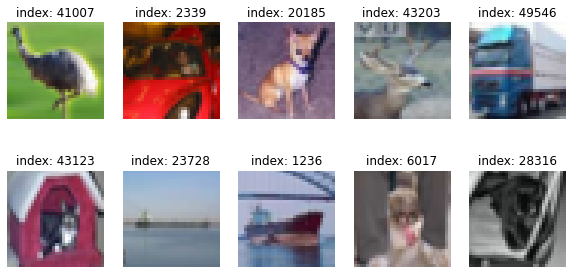

In [4]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
    
plt.show()

### - 데이터 정규화
0\~255 사이의 픽셀값을 -1\~1로 정규화시켜 사용한다.


In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
train_x = train_x / 127.5 - 1# 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


미니 배치 학습을 하기 위한 배치 사이즈와 데이터를 전체적으로 섞을 수 있도록 버퍼 사이즈를 지정한다. 

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

tensorflow의 Dataset을 이용하여 데이터를 섞어준다.  

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 모델 설계 및 훈련

### - 생성자(Generator) 설계

생성자는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지를 생성한다.  
CIFAR-10 데이터와 동일하게 (32, 32, 3) shape의 이미지를 생성할 수 있도록 한다.  

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만든 후 노이즈로부터 이미지를 생성할 수 있도록 생성자에 넣어준다.

In [12]:
# 노이즈 생성
noise = tf.random.normal([1, 100])

# 노이즈로부터 이미지 생성
generated_image = generator(noise, training=False)   # 학습중이 아니므로 training=False
generated_image.shape

TensorShape([1, 32, 32, 3])

생성된 이미지를 시각화해보자.  
이때, matplotlib 라이브러리는 2차원의 이미지만 표시할 수 있으므로 (32, 32) shape만 꺼내서 사용한다.

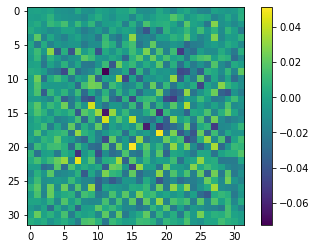

In [13]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### - 판별자(Discriminator) 설계

판별자는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 real인지 fake인지 판단하여 실숫값으로 출력한다.  
따라서 출력은 단 하나의 숫자이다.

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

노이즈로부터 생성자를 거쳐 생성된 이미지를 판별자에 넣어주면 (1, 1)의 텐서가 출력된다.

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0037573]], dtype=float32)>

### - 손실함수와 최적화함수

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.  
특히 판별자는 이미지가 진짜인지 가짜인지 2개의 클래스로 분류하므로 이진 교차 엔트로피(binary cross entropy)를 사용한다.  

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

생성자와 판별자의 정확도를 따로 계산해서 비교하는 것은 GAN의 학습에서 매우 유용하다.  
real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다.

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

최적화 함수로는 생성자와 판별자 모델 둘 다 Adam을 사용한다.  
다만, 생성자와 판별자는 각각 학습을 하는 개별 네트워크이므로 최적화 함수를 따로 정의해야 한다.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### - 훈련 과정 설계

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    np_predictions = predictions.numpy()
    np_predictions = (np_predictions + 1) * 127.5 # 정규화 했던 것을 되돌리기
    np_predictions = np_predictions.astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(np_predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_predictions[i])
        plt.axis('off')
   
    plt.savefig('./generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

    plt.show()

In [24]:
rcParams['figure.figsize'] = 15, 15    # matlab 차트의 기본 크기를 15,15로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['real_accuracy'])  
    plt.plot(history['fake_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['real_accuracy', 'fake_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('./training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [25]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### - 모델 학습

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 700

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

커널이 죽으면서 학습이 반쯤 진행된 시점에 중단되었다.  
파이썬 파일을 이용하여 Cloud Shell에서 학습을 진행하였다.  
학습에 사용한 파이썬 파일은 [여기]()에서 확인 가능하다.

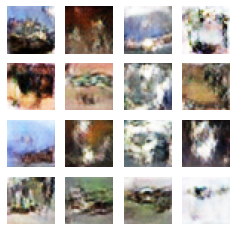

Time for training : 3869 sec


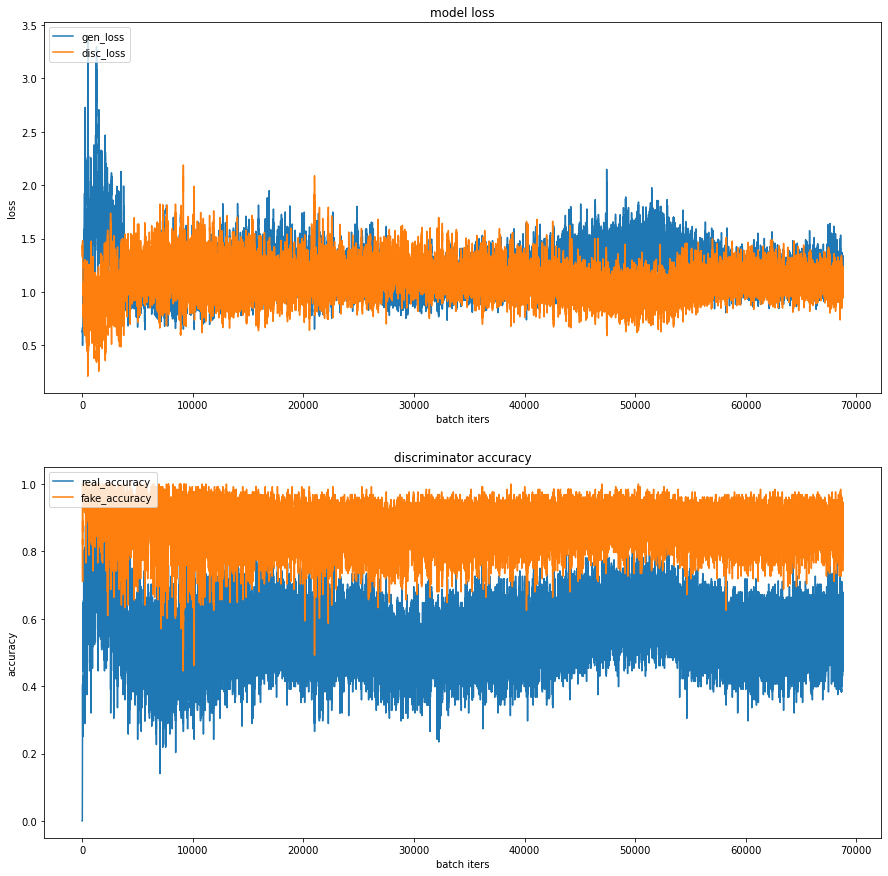

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = './cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#### 결과 확인

학습 진행 후 저장된 샘플들과 그래프를 확인해보자.

- generated sample
![sample](./sample_gif/cifar_dcgan.gif)

- training history
![history](./train_history/train_history_orig.png)

fake accuracy가 0.5 근처에 도달하지도 못하고 그러한 추세도 보이지 않는다.  
모델 개선이 필요할 것 같다.  
그래도 모델이 생성하는 이미지를 확인해보자!

In [28]:
# 저장된 체크포인트 불러오기
checkpoint_dir = './training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

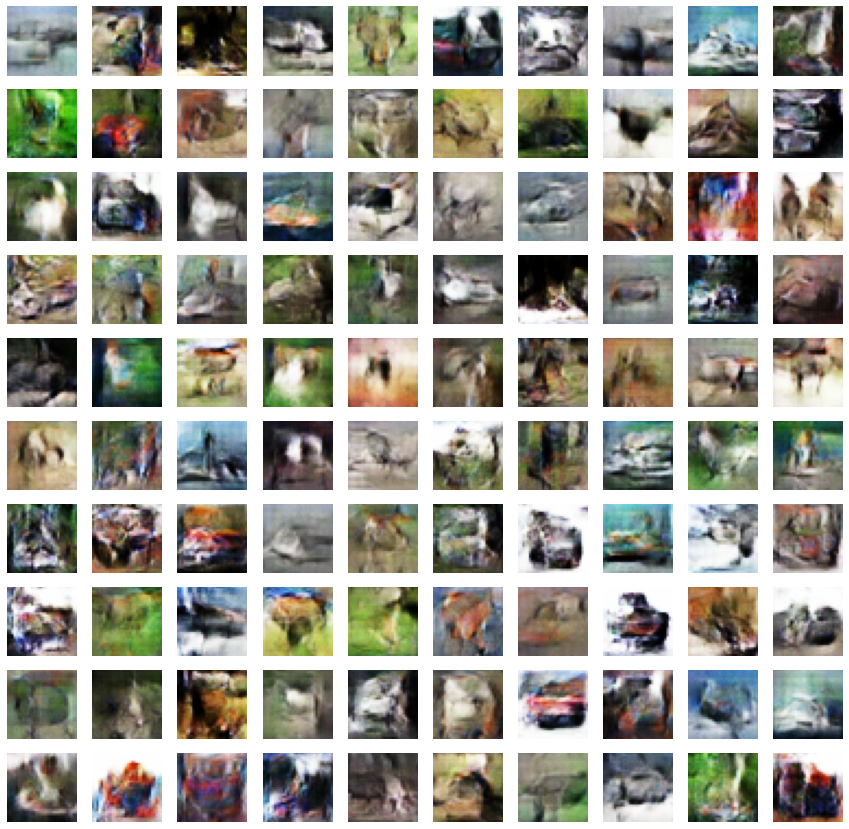

In [29]:
# 모델이 생성하는 이미지 확인
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False) # 이미지 생성
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated + 1) * 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

정확하게 무엇이라고 할 수는 없지만 어쩐지 조금만 노력하면 동물이 될 수 있을 것만 같은 이미지들이다.  
모델을 개선하여 조금 더 확실한 이미지를 얻어보겠다.

## 모델 개선

- 학습률 조정
- 학습률 조정 + LeakyRelu alpha 값 조정
- 학습률 조정 + 레이어 추가

### 학습률 조정
optimizer인 Adam에서 학습률과 beta1 값을 조정한 결과를 살펴보자.



- generated sample
![sample2](./sample_gif/cifar_dcgan_ver1.gif)

- training history

![history2](./train_history/train_history_ver1.png)

학습 후반부로 갈 수록 fake accuracy가 0.5 아래로 내려가는 배치가 많이 보인다.  
기존의 모델보다는 수치상으로 더 좋아보인다.  
모델이 생성하는 이미지로 직접 확인해보자.

- 저장된 체크포인트 불러오기

In [30]:
generator_optimizer2 = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4, 0.5)

In [31]:
checkpoint2 = tf.train.Checkpoint(generator_optimizer=generator_optimizer2,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
# 저장된 체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/ex10_dcgan_newimage/ver1/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint2.restore(latest)

generator2 = checkpoint2.generator
discriminator2 = checkpoint2.discriminator

- 생성 이미지 확인

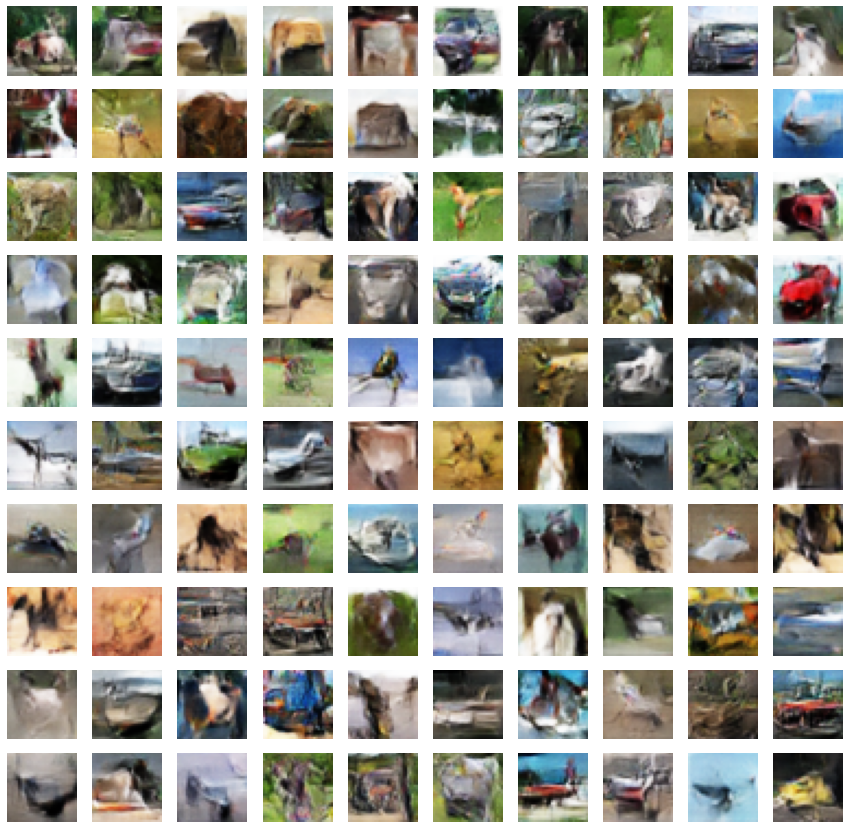

In [33]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator2(noise, training=False)
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated + 1) * 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

### 학습률 조정 + LeakyReLU 조정

In [40]:
def make_generator_model_leaky():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  # alpha=0.1

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [41]:
def make_discriminator_model_leaky():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [42]:
generator3 = make_generator_model_leaky()
discriminator3 = make_discriminator_model_leaky()

In [43]:
checkpoint3 = tf.train.Checkpoint(generator_optimizer=generator_optimizer2,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator3,
                                 discriminator=discriminator3)

In [44]:
# 저장된 체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/ex10_dcgan_newimage/ver2/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint3.restore(latest)

generator3 = checkpoint3.generator
discriminator3 = checkpoint3.discriminator

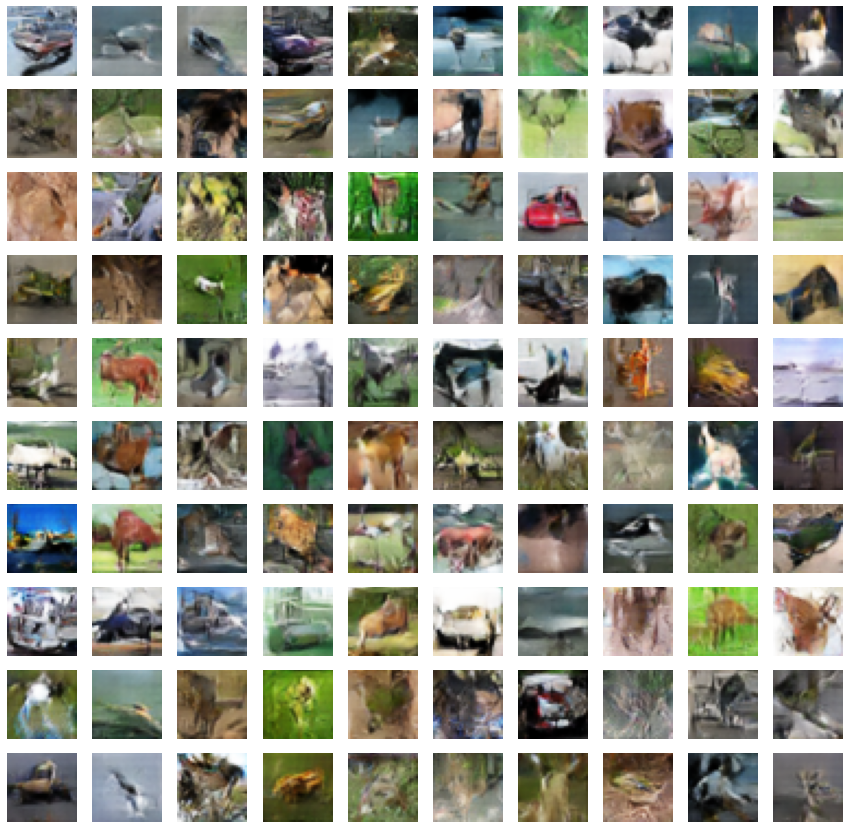

In [45]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator3(noise, training=False)
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

좋은 선택은 아닌 것 같다.. 흐릿..  

# 레이어 추가

- 시간 관계상 500 에폭만 학습

In [46]:
def make_generator_model_addLayer():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # 레이어 추가
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [47]:
generator4 = make_generator_model_addLayer()

generator4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 256)         1638400   
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 256)        

In [48]:
def make_discriminator_model_addLayer():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 레이어 추가
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [49]:
discriminator4 = make_discriminator_model_addLayer()

discriminator4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)        

In [50]:
checkpoint4 = tf.train.Checkpoint(generator_optimizer=generator_optimizer2,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator4,
                                 discriminator=discriminator4)

In [51]:
# 저장된 체크포인트 불러오기
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/ex10_dcgan_newimage/ver3/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint4.restore(latest)

generator4 = checkpoint4.generator
discriminator4 = checkpoint4.discriminator

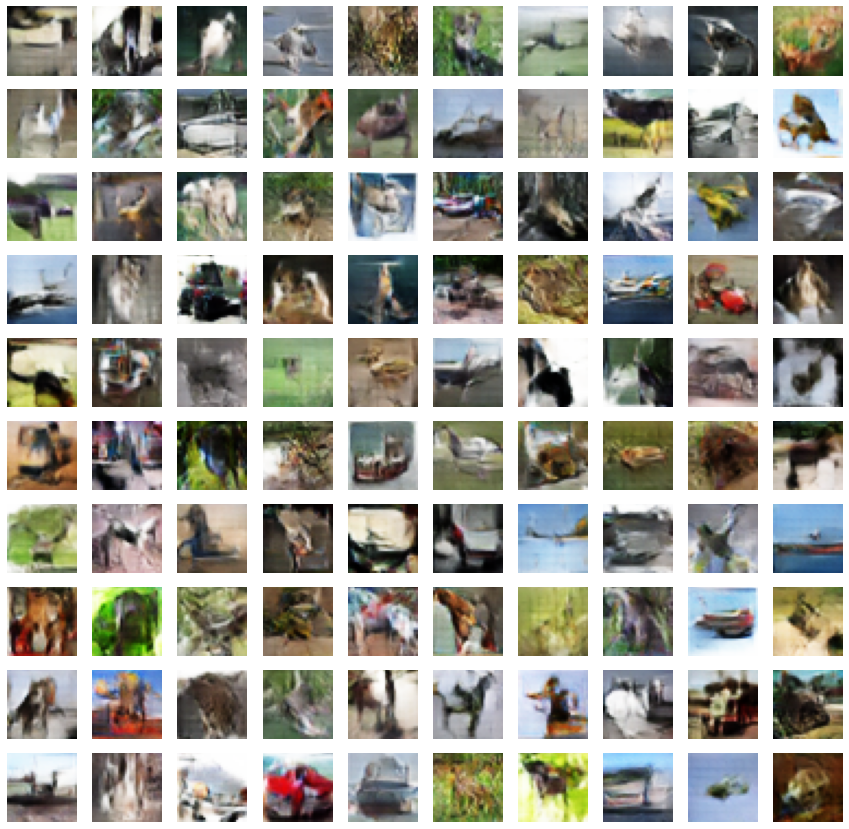

In [52]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator4(noise, training=False)
    
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5
    np_generated = np_generated.astype(int)
    
    plt.imshow(np_generated[0])
    plt.axis('off')

plt.show()

다른 이미지들 보다 바둑판 무늬가 선명   
모델 쌓을 때 고려했어야 하는데;; 잘 몰라서 못했더니 바둑판 무늬가 잘 보임...